In [1]:
%matplotlib inline
import pylab as pl

In [2]:
from astropy import units as u

In [3]:
from astropy.table import Table

In [4]:
import imf

In [5]:
import glob

In [10]:
from sedfitter.sed import SEDCube

In [6]:
version = 'r+23_models-1.1'

In [7]:
pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/{version}/s---s-i/parameters.fits')

In [8]:
path=f'/blue/adamginsburg/richardson.t/research/flux/{version}/s---s-i/convolved/JWST/'

In [9]:
geoms = [x.split("/")[-2] for x in glob.glob(f'/blue/adamginsburg/richardson.t/research/flux/{version}/*/')
         if x.split("/")[-2].startswith('s')]

In [10]:
augpars_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/{version}/{geom}/parameters.fits')
                for geom in geoms}
for key in augpars_dict:
    augpars_dict[key].add_index("MODEL_NAME")

In [7]:
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/*/')
         if x.split("/")[-2].startswith('s')]
geoms

['s---s-i',
 's-pbsmi',
 's-p-hmi',
 'spu-hmi',
 'spubsmi',
 's-pbhmi',
 's-u-smi',
 's-ubhmi',
 'spu-smi',
 's-u-hmi',
 's-ubsmi',
 'sp--hmi',
 'sp--s-i',
 'spubhmi',
 's---smi',
 'sp--smi',
 's-p-smi',
 'sp--h-i']

In [11]:
for geom in geoms:
    pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/{version}/pars/{geom}_augmented.fits')
    seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/flux.fits')
    break

In [69]:
flux_b7 = 98*u.mJy
flux_b3 = 1.77*u.mJy
ulim_24um = (1.25*u.Jy).to(u.mJy)
ulim_70um = (73.9*u.Jy).to(u.mJy)

In [70]:
seds.val.unit

Unit("mJy")

In [71]:
from astropy.visualization import quantity_support

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 179
spubsmi
spubsmi 119
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 65
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 14
spubhmi
spubhmi 505
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 5


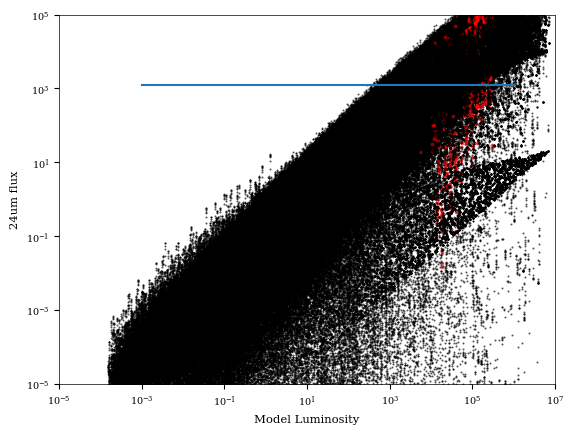

In [72]:
with quantity_support():
    for geometry in geoms:
    
        print(geometry)
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
        if 'disk.mass' in pars.colnames:
            seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
            pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
            pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
            pars['f24um'] = seds.val[:,7,81]
            pars['f70um'] = seds.val[:,7,64]
    
            sel = (pars['f0.8mm'] / 8.5**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.5**2 < flux_b7*1.25)
            #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
            print(geometry, sel.sum())
            pl.scatter(pars['Model Luminosity'], pars['f24um']/8.5**2, s=1, alpha=0.5, color='k')
            axlims = pl.gca().axis()
            pl.scatter(pars['Model Luminosity'][sel], pars['f24um'][sel]/8.5**2, s=5, alpha=0.5, label=geometry, color='r')

    #pl.gca().axis(axlims)
    pl.loglog()
    pl.plot([1e-3, 1e6]*u.L_sun, u.Quantity([ulim_24um, ulim_24um]))
    #pl.legend(loc='best')
    pl.ylabel("24um flux");
    pl.xlabel("Model Luminosity")
pl.axis([1e-5, 1e7, 1e-5, 1e5]);

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 179
spubsmi
spubsmi 119
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 65
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 14
spubhmi
spubhmi 505
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 5


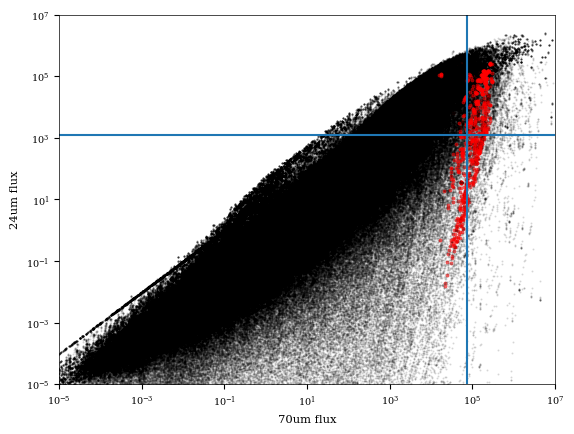

In [73]:
with quantity_support():
    for geometry in geoms:
    
        print(geometry)
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
        if 'disk.mass' in pars.colnames:
            seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
            pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
            pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
            pars['f24um'] = seds.val[:,7,81]
            pars['f70um'] = seds.val[:,7,64]
    
            sel = (pars['f0.8mm'] / 8.5**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.5**2 < flux_b7*1.25)
            #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
            print(geometry, sel.sum())
            pl.scatter(pars['f70um']/8.5**2, pars['f24um']/8.5**2, s=1, alpha=0.1, color='k')
            pl.scatter(pars['f70um'][sel]/8.5**2, pars['f24um'][sel]/8.5**2, s=5, alpha=0.5, label=geometry, color='r')
    
    pl.loglog()
    pl.axhline(ulim_24um)
    pl.axvline(ulim_70um)
    #pl.legend(loc='best')
    pl.ylabel("24um flux");
    pl.xlabel("70um flux");
pl.axis([1e-5, 1e7, 1e-5, 1e7]);

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 198
spubsmi
spubsmi 128
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 69
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 14
spubhmi
spubhmi 730
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 5


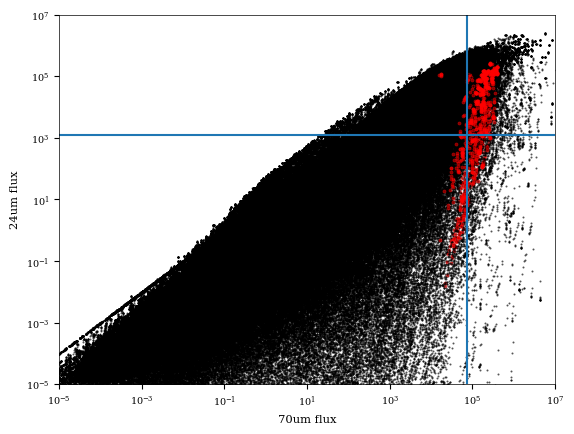

In [74]:
with quantity_support():
    for geometry in geoms:
    
        print(geometry)
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
        if 'disk.mass' in pars.colnames:
            seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
            pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
            pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
            pars['f24um'] = seds.val[:,7,81]
            pars['f70um'] = seds.val[:,7,64]
    
            sel = (((pars['f0.8mm'] / 8.5**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.5**2 < flux_b7*1.25))
                   | ((pars['f3mm'] / 8.5**2 > flux_b3*0.75) & (pars['f3mm'] / 8.5**2 < flux_b3*1.25)))
            #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
            print(geometry, sel.sum())
            pl.scatter(pars['f70um']/8.5**2, pars['f24um']/8.5**2, s=1, alpha=0.5, color='k')
            pl.scatter(pars['f70um'][sel]/8.5**2, pars['f24um'][sel]/8.5**2, s=5, alpha=0.5, label=geometry, color='r')
    
    pl.loglog()
    pl.axhline(ulim_24um)
    pl.axvline(ulim_70um)
    #pl.legend(loc='best')
    pl.ylabel("24um flux");
    pl.xlabel("70um flux");
pl.axis([1e-5, 1e7, 1e-5, 1e7]);

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 55
spubsmi
spubsmi 15
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 27
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 0
spubhmi
spubhmi 129
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 0


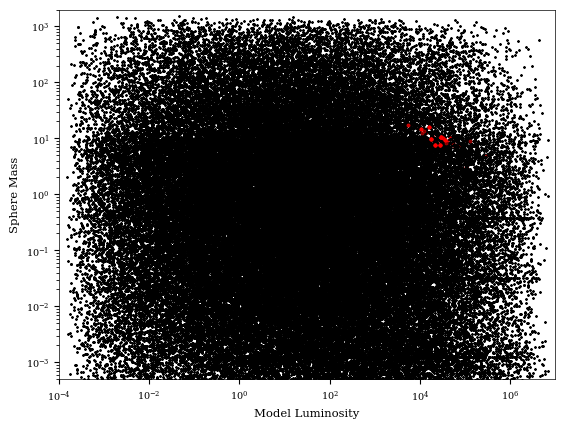

In [76]:
with quantity_support():
    for geometry in geoms:
    
        print(geometry)
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
        if 'disk.mass' in pars.colnames:
            seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
            pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
            pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
            pars['f24um'] = seds.val[:,7,81]
            pars['f70um'] = seds.val[:,7,64]
    
            sel = (((pars['f0.8mm'] / 8.5**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.5**2 < flux_b7*1.25))
                   | ((pars['f3mm'] / 8.5**2 > flux_b3*0.75) & (pars['f3mm'] / 8.5**2 < flux_b3*1.25)))
            sel &= pars['f70um'] / 8.5 ** 2 < ulim_70um
            sel &= pars['f24um'] / 8.5 ** 2 < ulim_24um
            #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
            print(geometry, sel.sum())
            pl.scatter(pars['Model Luminosity'], pars['Sphere Masses'][:,7], s=1, alpha=0.5, color='k')
            pl.scatter(pars['Model Luminosity'][sel], pars['Sphere Masses'][:,7][sel], s=5, alpha=0.5, label=geometry, color='r')
    
    pl.loglog()
    #pl.axhline(ulim_24um)
    #pl.axvline(ulim_70um)
    #pl.legend(loc='best')
    pl.ylabel("Sphere Mass");
    pl.xlabel("Model Luminosity");
pl.axis([1e-4, 1e7, 5e-4, 2e3]);

In [19]:
seds.apertures[7]
seds.wav[27]

<Quantity 822.92758008 um>

In [34]:
seds.wav[81]

<Quantity 23.80343957 um>

In [41]:
seds.wav[64]

<Quantity 72.61931817 um>

In [22]:
seds.apertures[7]
seds.wav[7]

<Quantity 3056.74083122 um>

In [25]:
seds.wav.shape

(200,)

In [27]:
seds.val.shape

(90000, 20, 200)